# Project 3: Gaussian Mixture Model
\
- Features will be selected using Uniform Manifold Approximation and Projection (UMAP), in order to project the features in lower dimensions to visualize the clustering results and decrease computational complexity.

- The number of clusters where selected using cross validation with two methods:
    - Silhouette score
    - Elbow method



### Libraries

In [132]:
# General purpose:
import pandas as pd
import numpy as np
from itertools import combinations
import warnings

# Visualization:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Data formatting and modelling:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.mixture import GaussianMixture
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import silhouette_score, adjusted_rand_score
import umap


### Importing Data

In [ ]:
# Load catdog data set:
df_catdog = pd.read_csv('../project_2/catdogdata.txt', delimiter = ' ')
df_catdog['label'] = 0 # cats are the first 99 entries
df_catdog.loc[99:198, 'label'] = 1 # dogs are the next 99 entries

# Rotate all images 90 degrees clockwise
def rotate_image(image):
    return np.rot90(image.reshape(64, 64), -1).flatten()

# Apply the rotation to all rows and update the DataFrame
rotated_images = np.array([rotate_image(row.values) for _, row in df_catdog.iloc[:, :-1].iterrows()])
df_catdog.iloc[:, :-1] = rotated_images

# Load MNIST data set
df_mnist = pd.read_csv('../project_2/Numbers.txt', delimiter=' ')
df_mnist['label'] = df_mnist.iloc[:, 0]
df_mnist = df_mnist.iloc[:, 1:]


### 2D projection

In [94]:
# UMAP 2D projection of catdog data set
X_catdog = df_catdog.iloc[:, :-1].values
y_catdog = df_catdog.iloc[:, -1].values
umap_catdog = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2, n_jobs=1)
X_catdog_umap = umap_catdog.fit_transform(X_catdog)

# UMAP 2D projection of MNIST data set
X_mnist = df_mnist.iloc[:, :-1].values
y_mnist = df_mnist.iloc[:, -1].values
umap_mnist = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2, n_jobs=1, random_state=42)
X_mnist_umap = umap_mnist.fit_transform(X_mnist)


c:\Users\maxfr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\maxfr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Plot UMAP projections

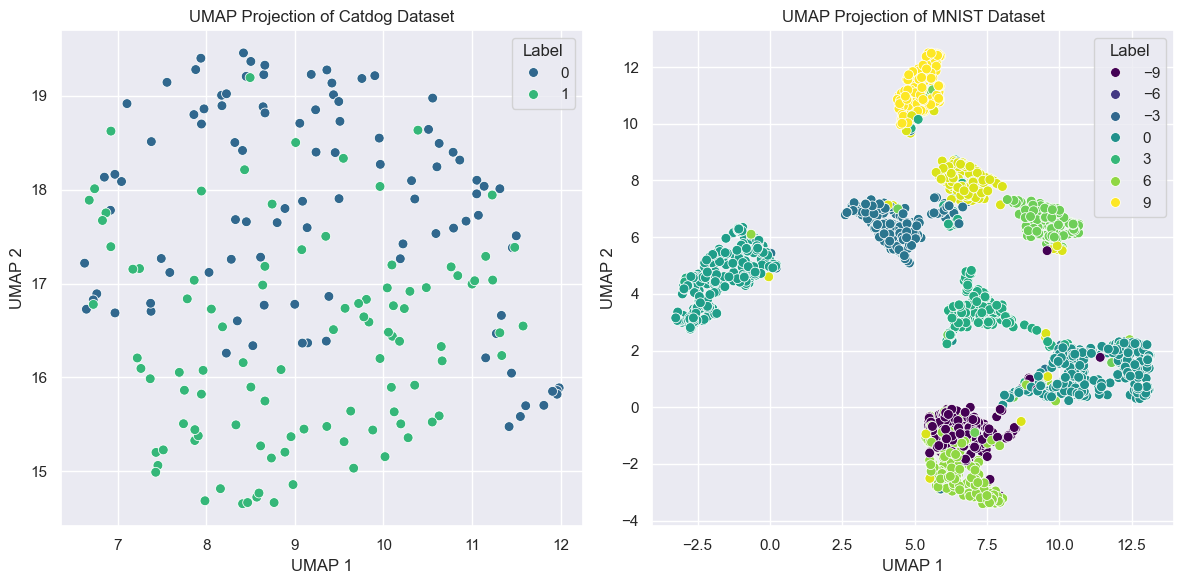

In [100]:
# Plot 2D projections
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
sns.set(style="darkgrid", palette="viridis")

# Catdog
sns.scatterplot(x=X_catdog_umap[:, 0], y=X_catdog_umap[:, 1], hue=y_catdog, palette='viridis', s=50, ax=ax1)
ax1.set_title('UMAP Projection of Catdog Dataset')
ax1.set_xlabel('UMAP 1')
ax1.set_ylabel('UMAP 2')
ax1.legend(title='Label')

# MNIST 
sns.scatterplot(x=X_mnist_umap[:, 0], y=X_mnist_umap[:, 1], hue=y_mnist, palette='viridis', s=50, ax=ax2)
ax2.set_title('UMAP Projection of MNIST Dataset')
ax2.set_xlabel('UMAP 1')
ax2.set_ylabel('UMAP 2')
ax2.legend(title='Label')

plt.tight_layout()
plt.show()

### Function for visualization

In [122]:
def plot_gmm_and_true_labels(X, y_true, gmm_model, label_names=None, title="GMM Clustering with True Labels"):
    """
    Plots GMM clustering results with decision boundaries alongside true labels.

    Parameters:
    - X: 2D numpy array of shape (n_samples, 2), the UMAP-reduced data.
    - y_true: 1D array-like of true labels (e.g., [0, 1]).
    - gmm_model: A fitted sklearn.mixture.GaussianMixture instance.
    - label_names: Optional dict mapping label values to strings (e.g., {0: "Cat", 1: "Dog"}).
    - title: Title of the entire figure.
    """
    n_components = gmm_model.n_components
    colors = sns.color_palette("Set2", n_components)
    cmap = ListedColormap(colors)

    y_pred = gmm_model.predict(X)

    # Set seaborn style
    sns.set(style="darkgrid", palette="viridis")

    # Create figure and axes
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))

    # GMM predictions with decision boundary
    DecisionBoundaryDisplay.from_estimator(
        gmm_model, X, response_method="predict", ax=ax1,
        alpha=0.6, cmap=cmap
    )

    sns.scatterplot(
        x=X[:, 0], y=X[:, 1], hue=y_pred,
        palette=colors, edgecolor="k", s=60, ax=ax1, legend=False
    )
    ax1.set_title("GMM Clustering", fontsize=14)
    ax1.set_xlabel("UMAP 1")
    ax1.set_ylabel("UMAP 2")

    # True labels
    sns.scatterplot(
        x=X[:, 0], y=X[:, 1], hue=y_true,
        palette=colors, edgecolor="k", s=60, ax=ax2, legend=True
    )
    ax2.set_title("True Labels", fontsize=14)
    ax2.set_xlabel("UMAP 1")
    ax2.set_ylabel("UMAP 2")

    # Custom legend if label names are provided
    if label_names:
        handles, _ = ax2.get_legend_handles_labels()
        sorted_labels = sorted(set(y_true))
        ax2.legend(handles=handles, labels=[label_names[i] for i in sorted_labels], title="Label")

    # Final formatting
    plt.suptitle(title, fontsize=16, y=1.03)
    sns.despine()
    plt.tight_layout()
    plt.show()


### Cross Validation for optimal number of clusters

In [136]:

def tune_gmm_params(X, param_grid, n_splits=5, random_state=42):
    silhouette_scores = []
    sumsq_errors = []

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # outer loop
    for k in param_grid:
        sil_fold_scores = []
        sse_fold_scores = []

        # inner loop
        for train_idx, _ in kf.split(X):
            X_train = X[train_idx]

            gmm = GaussianMixture(n_components=k, random_state=random_state)
            gmm.fit(X_train)
            labels = gmm.predict(X_train)
            centers = gmm.means_

            # Sum of squared distances to assigned cluster centers
            sse = np.sum([np.linalg.norm(x - centers[label]) ** 2 for x, label in zip(X_train, labels)])
            sse_fold_scores.append(sse)

            if k > 1:
                sil = silhouette_score(X_train, labels)
                sil_fold_scores.append(sil)

        # Average scores across folds
        silhouette_scores.append(np.mean(sil_fold_scores) if sil_fold_scores else np.nan)
        sumsq_errors.append(np.mean(sse_fold_scores))

    # --- Elbow Detection Function ---
    def find_elbow(x, y):
        x = np.array(x)
        y = np.array(y)
        p1 = np.array([x[0], y[0]])
        p2 = np.array([x[-1], y[-1]])
        line_vec = p2 - p1
        line_vec_norm = line_vec / np.linalg.norm(line_vec)
        distances = []
        for xi, yi in zip(x, y):
            p = np.array([xi, yi])
            vec_to_line = p - p1
            projection = np.dot(vec_to_line, line_vec_norm) * line_vec_norm
            orth_vec = vec_to_line - projection
            distances.append(np.linalg.norm(orth_vec))
        elbow_index = int(np.argmax(distances))
        return x[elbow_index]

    best_k_silhouette = param_grid[np.nanargmax(silhouette_scores)]
    best_k_elbow = find_elbow(param_grid, sumsq_errors)

    # --- Plotting ---
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    ax[0].plot(param_grid, silhouette_scores, marker='o')
    ax[0].axvline(best_k_silhouette, ls='--', c='gray', label='Best Silhouette')
    ax[0].set_title("CV Mean Silhouette Score")
    ax[0].set_xlabel("Number of Clusters")
    ax[0].set_ylabel("Silhouette")
    ax[0].legend()

    ax[1].plot(param_grid, sumsq_errors, marker='o')
    ax[1].axvline(best_k_elbow, ls='--', c='red', label='Elbow Point')
    ax[1].set_title("CV Mean Sum of Squares Error")
    ax[1].set_xlabel("Number of Clusters")
    ax[1].set_ylabel("SSE")
    ax[1].legend()

    plt.suptitle("GMM Cross-Validated Cluster Selection", fontsize=14)
    plt.tight_layout()
    plt.show()

    return best_k_silhouette, best_k_elbow


In [135]:
def assess_tuning_stability(X, param_grid, n_runs=10, n_splits=5):
    all_labels_ss = []
    all_labels_elbow = []
    list_best_k_ss = []
    list_best_k_elbow = []

    for i in range(n_runs):
        best_k_ss, best_k_elbow = tune_gmm_params(X, param_grid, n_splits=n_splits, random_state=42 + i)
        
        gmm_ss = GaussianMixture(n_components=best_k_ss).fit(X)
        labels_ss = gmm_ss.predict(X)
        all_labels_ss.append(labels_ss)
        list_best_k_ss.append(best_k_ss)

        gmm_elbow = GaussianMixture(n_components=best_k_elbow).fit(X)
        labels_elbow = gmm_elbow.predict(X)
        all_labels_elbow.append(labels_elbow)
        list_best_k_elbow.append(best_k_elbow)

    aris_ss = [adjusted_rand_score(all_labels_ss[i], all_labels_ss[j])
            for i, j in combinations(range(n_runs), 2)]
    
    aris_elbow = [adjusted_rand_score(all_labels_elbow[i], all_labels_elbow[j])
            for i, j in combinations(range(n_runs), 2)]

    print(f"##### Metrics using Silhouette score: #####\nAverage ARI across {n_runs} tuning runs: {np.mean(aris_ss):.4f}")
    print(f"Best k's across runs: {list_best_k_ss}")

    print(f"##### Metrics using Elbow method: #####\nAverage ARI across {n_runs} tuning runs: {np.mean(aris_elbow):.4f}")
    print(f"Best k's across runs: {list_best_k_elbow}")
    
    return aris_ss, list_best_k_ss, aris_elbow, list_best_k_elbow

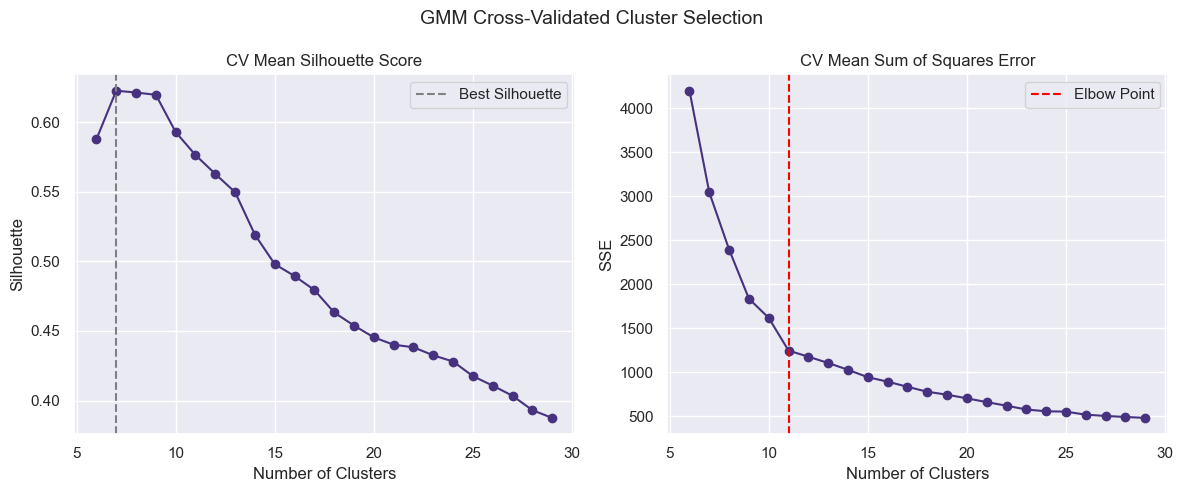

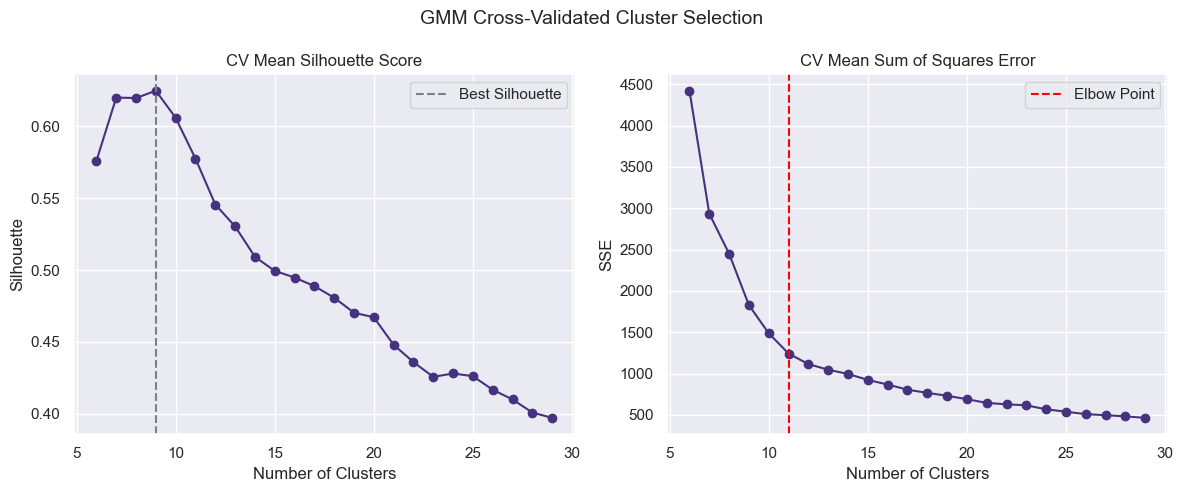

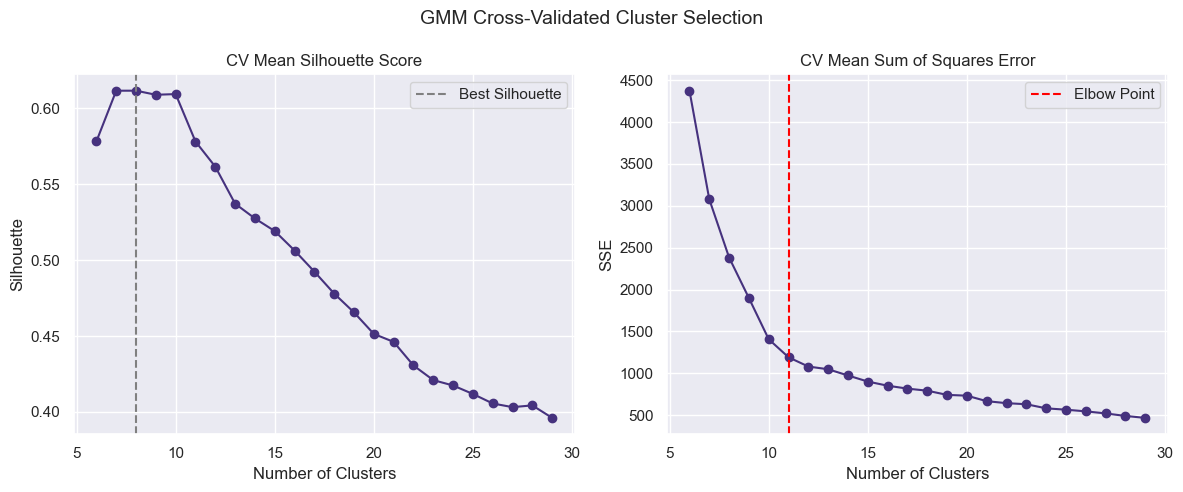

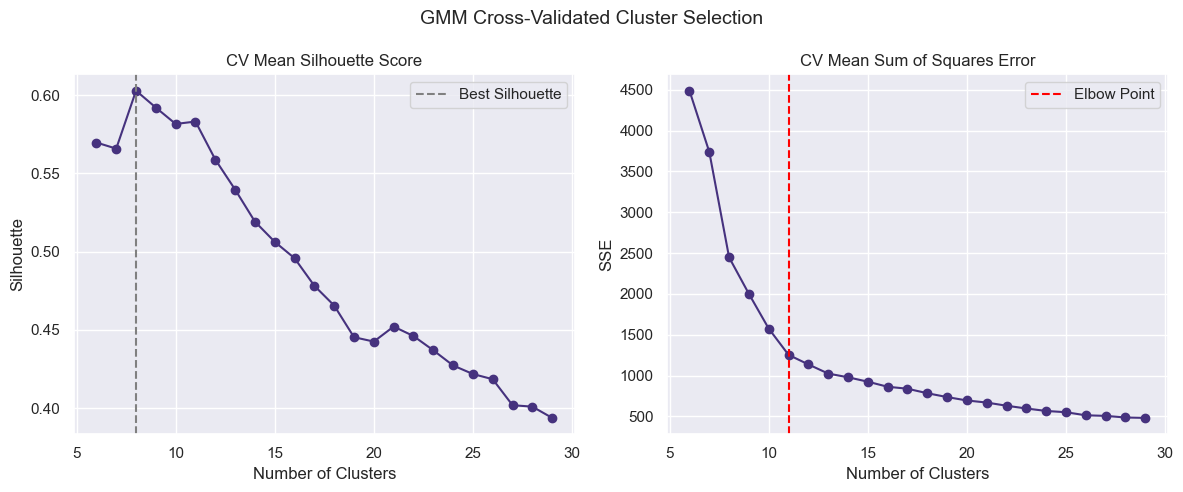

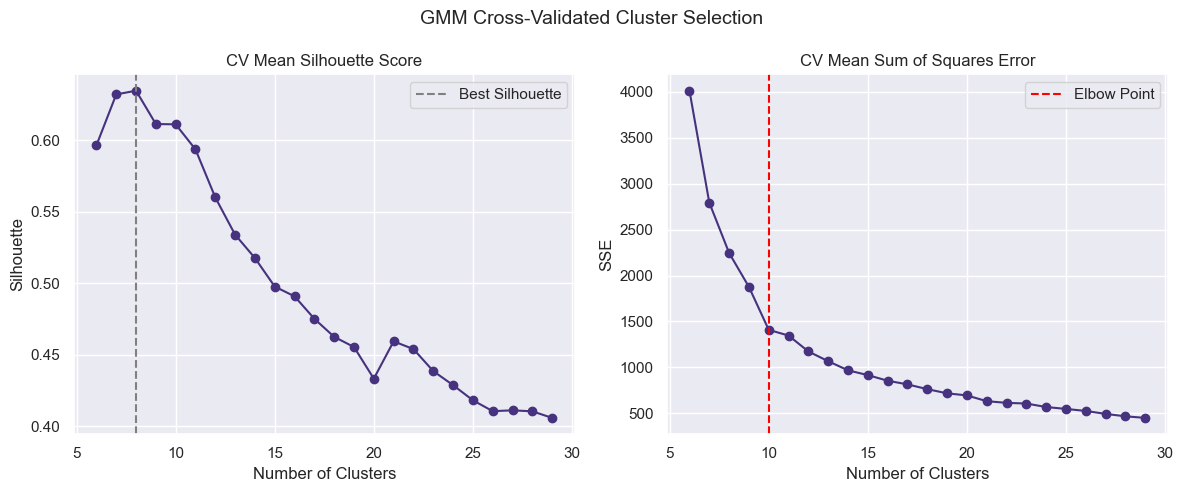

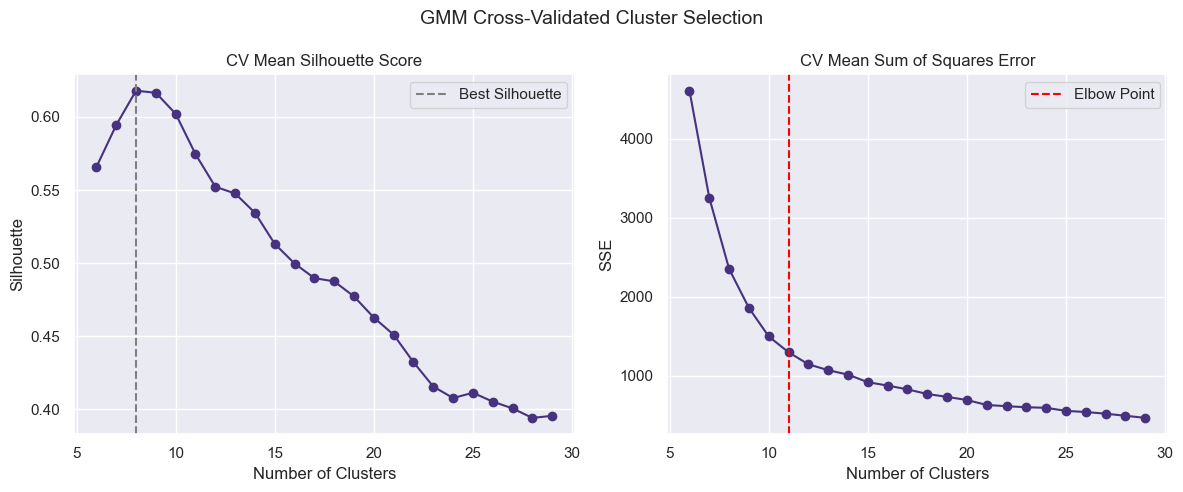

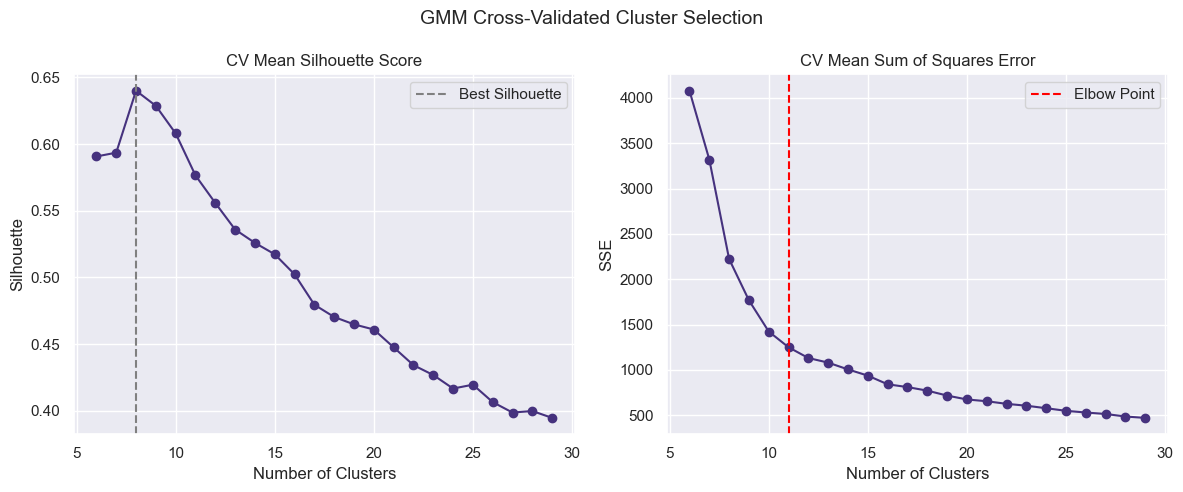

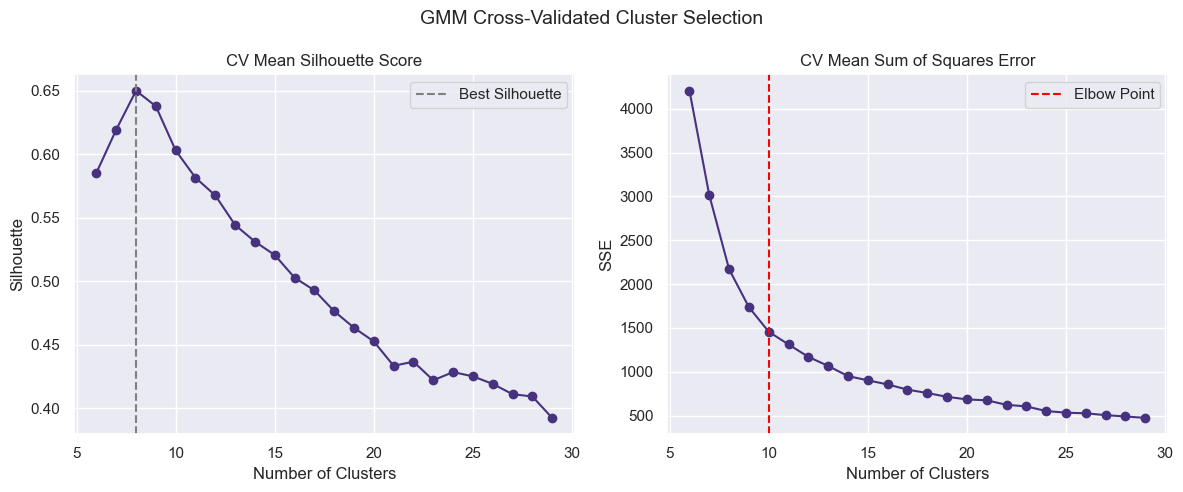

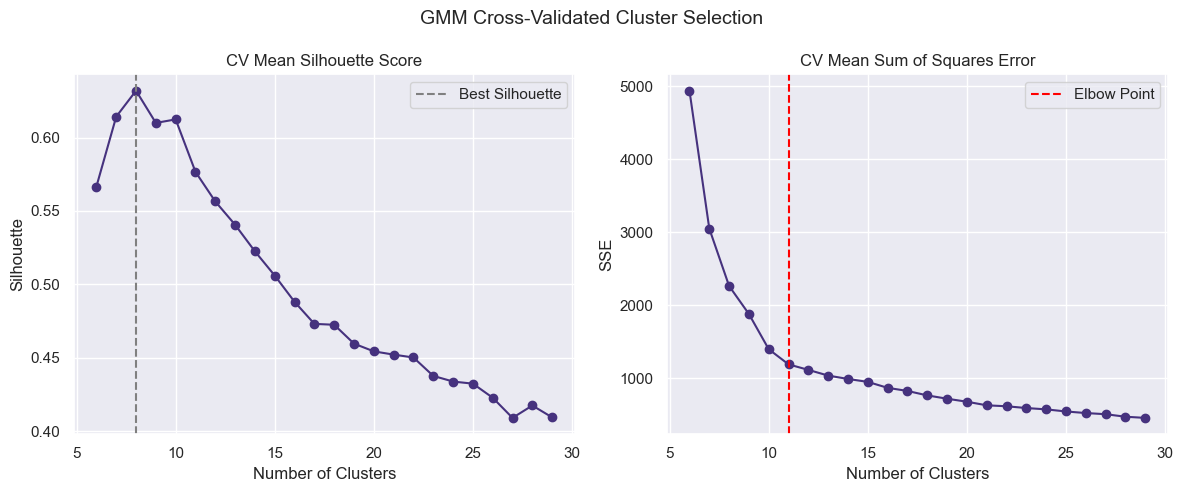

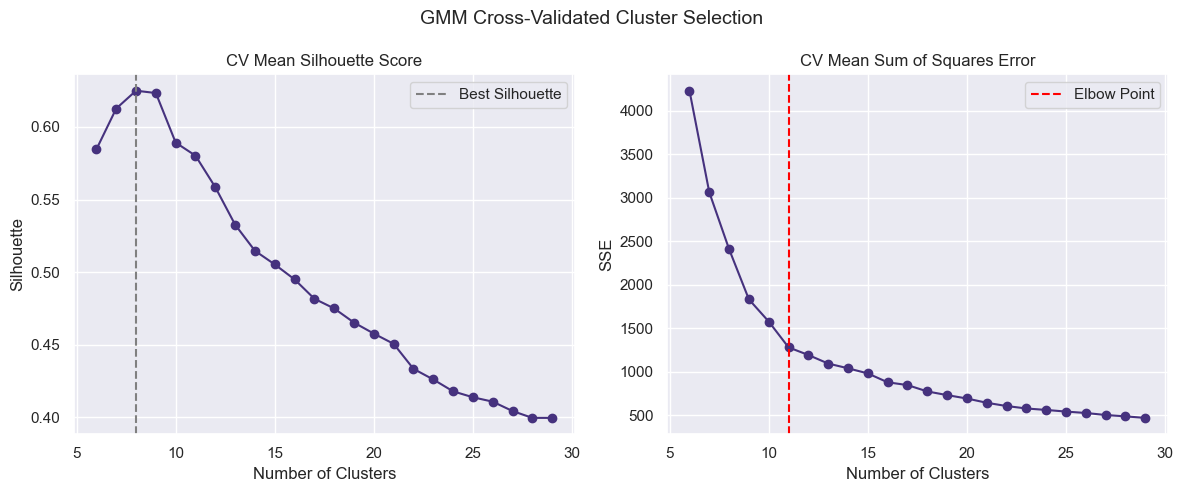

##### Metrics using Silhouette score: #####
Average ARI across 10 tuning runs: 0.9246
Best k's across runs: [7, 9, 8, 8, 8, 8, 8, 8, 8, 8]
##### Metrics using Elbow method: #####
Average ARI across 10 tuning runs: 0.8960
Best k's across runs: [np.int64(11), np.int64(11), np.int64(11), np.int64(11), np.int64(10), np.int64(11), np.int64(11), np.int64(10), np.int64(11), np.int64(11)]


ValueError: too many values to unpack (expected 2)

In [137]:
k_best_SS, k_best_Elbow = assess_tuning_stability(X_mnist_umap, [x for x in range(6,30)], 10, 5)

AttributeError: 'GaussianMixture' object has no attribute 'labels_'

In [14]:
import numpy as np

from sklearn.datasets import make_blobs

n_samples = 1500
random_state = 170
transformation = [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]

X, y = make_blobs(n_samples=n_samples, random_state=random_state)
X_aniso = np.dot(X, transformation)  # Anisotropic blobs
X_varied, y_varied = make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)  # Unequal variance
X_filtered = np.vstack(
    (X[y == 0][:500], X[y == 1][:100], X[y == 2][:10])
)  # Unevenly sized blobs
y_filtered = [0] * 500 + [1] * 100 + [2] * 10

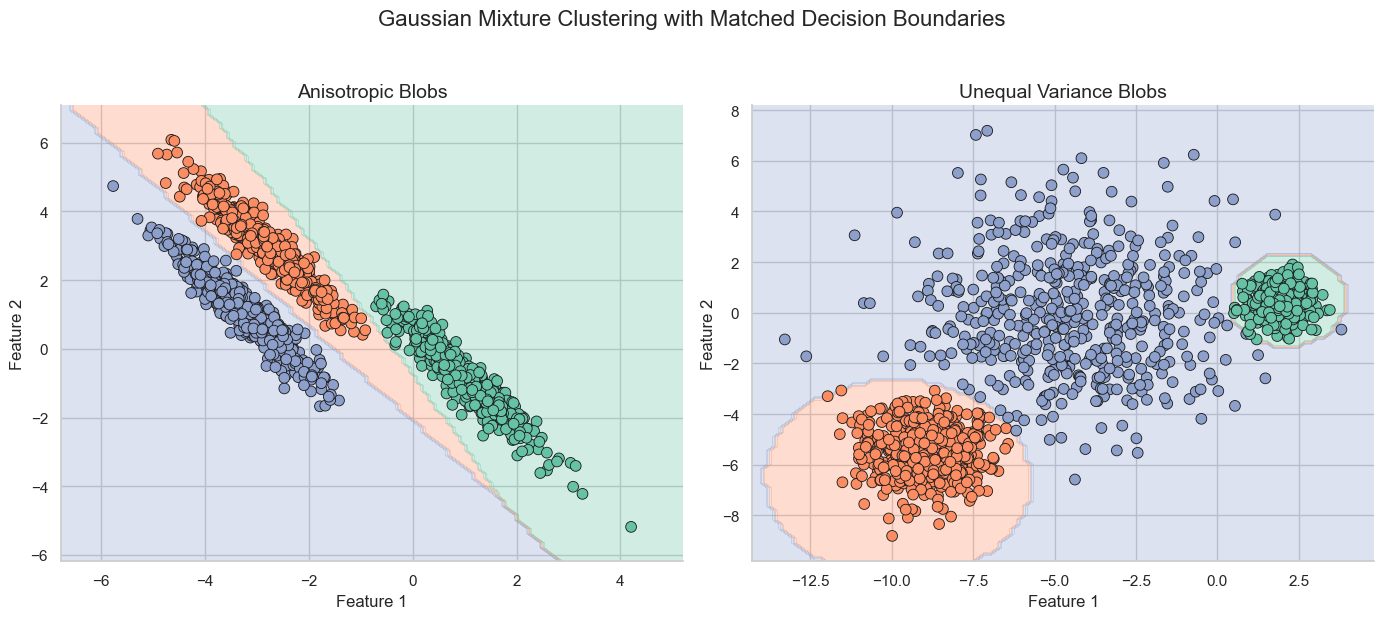

In [ ]:
# SKLEARN EXAMPLE

# Set seaborn style
sns.set(style="whitegrid", palette="muted")

# Define a consistent color palette
n_components = 3
colors = sns.color_palette("Set2", n_components)
cmap = ListedColormap(colors)

# Create figure and axes
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6))

# --- Plot 1: Anisotropic blobs ---
gm1 = GaussianMixture(n_components=n_components, random_state=0).fit(X_aniso)
y_pred1 = gm1.predict(X_aniso)

disp1 = DecisionBoundaryDisplay.from_estimator(
    gm1, X_aniso, response_method="predict", ax=ax1,
    alpha=0.3, cmap=cmap
)

sns.scatterplot(
    x=X_aniso[:, 0], y=X_aniso[:, 1], hue=y_pred1,
    palette=colors, edgecolor="k", s=60, ax=ax1, legend=False
)
ax1.set_title("Anisotropic Blobs", fontsize=14)
ax1.set_xlabel("Feature 1")
ax1.set_ylabel("Feature 2")

# --- Plot 2: Unequal variance blobs ---
gm2 = GaussianMixture(n_components=n_components, random_state=0).fit(X_varied)
y_pred2 = gm2.predict(X_varied)

disp2 = DecisionBoundaryDisplay.from_estimator(
    gm2, X_varied, response_method="predict", ax=ax2,
    alpha=0.3, cmap=cmap
)

sns.scatterplot(
    x=X_varied[:, 0], y=X_varied[:, 1], hue=y_pred2,
    palette=colors, edgecolor="k", s=60, ax=ax2, legend=False
)
ax2.set_title("Unequal Variance Blobs", fontsize=14)
ax2.set_xlabel("Feature 1")
ax2.set_ylabel("Feature 2")

# Final formatting
plt.suptitle("Gaussian Mixture Clustering with Matched Decision Boundaries", fontsize=16, y=1.03)
sns.despine()
plt.tight_layout()
plt.show()
